![ECMWF](logo.png)
#  A simple false-colour scheme for the representation of multi-layer clouds


This notebook will illustrate the method used at ECMWF to create one of the opencharts products as described in [the ECMWF newsletter (page 30)](https://www.ecmwf.int/sites/default/files/elibrary/2004/14657-newsletter-no101-summerautumn-2004.pdf).

This product for the current forecast can be found in [the ECMWF opencharts application](https://apps.ecmwf.int/webapps/opencharts/products/medium-clouds).

![Total Cloud Cover example](opencharts-totalcloudcover.png) 

A ‘synthetic’cloud field is defined as the combination of the three Low/Medium/High Cloud Cover and a 64-colour table is associated to it each values. 



## Retrieve Data 

This product takes in input 3 parameters : 
* [Low cloud cover](https://apps.ecmwf.int/codes/grib/param-db/?id=186)
* [Medium cloud cover](https://apps.ecmwf.int/codes/grib/param-db/?id=187)
* [High cloud cover](https://apps.ecmwf.int/codes/grib/param-db/?id=188)

In this example we show how to retrieve them from ECMWF Reanalysis v5 (ERA5) available on the [Climate Data Store](https://cds.climate.copernicus.eu)

You can configure your request on [the interactive page]( https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form)

For this example, I choose the Low/Medium/and high Cloud cover on a specific data and cust and paste the API request in the cell below.
I also followed the instructions to set up my [API key](https://cds.climate.copernicus.eu/api-how-to) 

In case you do not want to retrieve data or you are on Binder, we have put an example file then you can directly go to the [compute step](#compute). 

But if you retrieve data, you will be able to see what the cloud cover on your birth day or any other day. 

In [15]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            'high_cloud_cover', 'low_cloud_cover', 'medium_cloud_cover',
        ],
        'year': '2020',
        'month': '05',
        'day': '12',
        'time': '00:00',
        'format': 'netcdf',
    },
    'clouds.nc')

2021-05-03 14:46:21,294 INFO Welcome to the CDS
2021-05-03 14:46:21,295 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2021-05-03 14:46:22,307 INFO Request is completed
2021-05-03 14:46:22,308 INFO Downloading https://download-0001.copernicus-climate.eu/cache-compute-0001/cache/data7/adaptor.mars.internal-1620049366.5935194-8466-13-f551632d-1af5-4b15-91f6-1d6737eff833.nc to clouds.nc (6M)
2021-05-03 14:46:22,929 INFO Download rate 9.6M/s   


Result(content_length=6239636,content_type=application/x-netcdf,location=https://download-0001.copernicus-climate.eu/cache-compute-0001/cache/data7/adaptor.mars.internal-1620049366.5935194-8466-13-f551632d-1af5-4b15-91f6-1d6737eff833.nc)

## Compute the synthetic cloud layer 

The 3 layers Low/Medium/hi Cloud cover are now available in a netcdf file ( clouds.nc ) 


In [1]:
import xarray as xr
cloud = xr.open_dataset("clouds.nc")
cloud

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-05-12
Data variables:
    hcc        (time, latitude, longitude) float32 ...
    lcc        (time, latitude, longitude) float32 ...
    mcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-05-03 13:42:47 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

We perform a simple computation 
and save the result in a new netcdf compute.nc 

In [2]:
colour_resol = 4
lcc = cloud["lcc"].values  * (colour_resol-1) + 0.5
lcc = lcc.astype(int)
mcc = cloud["mcc"].values  * (colour_resol-1) + 0.5
mcc = mcc.astype(int)
hcc = cloud["hcc"].values  * (colour_resol-1) + 0.5
hcc  = hcc.astype(int)
combined = (colour_resol*colour_resol)*hcc+(colour_resol * mcc)+lcc
combined = xr.Dataset(
    {
         "combined": (
             ("time", "latitude", "longitude"),
             combined
         ),
         "latitude": cloud.latitude,
         "longitude": cloud.longitude,
         "time": cloud.time
     }
    
 )
combined.to_netcdf("combined.nc")
combined

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2020-05-12
Data variables:
    combined   (time, latitude, longitude) int64 11 11 11 11 11 11 ... 7 7 7 7 7

## Use Magics ( ECMWF package ) to visualise the data 

[Magics](https://confluence.ecmwf.int/display/MAGP/Magics) is a visualisation package specialised in meteorological visualisation. 
Its simple interface allows to quickly visualise GRIB and NetCDF data on the any geographical areas and on a large variety of projections.

Magics can be installed from pypi  
`pip install magics`

In [3]:
from Magics import macro as magics

import json

def plot(area = "global"):
    cont_list = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,
             10.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5,
             20.5,21.5,22.5,23.5,24.5,25.5,26.5,27.5,28.5,29.5,
             30.5,31.5,32.5,33.5,34.5,35.5,36.5,37.5,38.5,39.5,
             40.5,41.5,42.5,43.5,44.5,45.5,46.5,47.5,48.5,49.5,
             50.5,51.5,52.5,53.5,54.5,55.5,56.5,57.5,58.5,59.5,
             60.5,61.5,62.5,63.5]

    col_list=['HSL(0,0,1)','HSL(29,0.12,0.92)','HSL(29,0.23,0.83)','HSL(29,0.35,0.75)',
            'HSL(300,0.12,0.92)','HSL(344,0.17,0.84)','HSL(2,0.26,0.75)','HSL(10,0.37,0.67)',
            'HSL(300,0.23,0.83)','HSL(326,0.26,0.75)','HSL(344,0.34,0.67)','HSL(355,0.43,0.58)',
            'HSL(300,0.35,0.75)','HSL(318,0.37,0.67)','HSL(333,0.43,0.58)','HSL(344,0.5,0.5)',
            'HSL(180,0.17,0.92)','HSL(138,0.08,0.84)','HSL(70,0.12,0.75)','HSL(50,0.22,0.67)',
            'HSL(223,0.15,0.84)','HSL(262,0.04,0.75)','HSL(7,0.1,0.67)','HSL(19,0.21,0.59)',
            'HSL(256,0.21,0.75)','HSL(289,0.16,0.67)','HSL(330,0.18,0.58)','HSL(352,0.26,0.5)',
            'HSL(271,0.3,0.67)','HSL(294,0.27,0.59)','HSL(318,0.29,0.5)','HSL(337,0.34,0.42)',
            'HSL(180,0.34,0.83)','HSL(166,0.24,0.75)','HSL(138,0.17,0.67)','HSL(99,0.17,0.58)',
            'HSL(199,0.29,0.75)','HSL(194,0.18,0.67)','HSL(169,0.07,0.58)','HSL(67,0.08,0.5)',
            'HSL(223,0.3,0.67)','HSL(231,0.19,0.58)','HSL(262,0.09,0.5)','HSL(339,0.1,0.42)',
            'HSL(242,0.34,0.58)','HSL(256,0.25,0.5)','HSL(283,0.2,0.42)','HSL(317,0.2,0.33)',
            'HSL(180,0.5,0.75)','HSL(171,0.4,0.67)','HSL(158,0.32,0.58)','HSL(138,0.26,0.5)',
            'HSL(192,0.45,0.67)','HSL(187,0.34,0.59)','HSL(176,0.24,0.5)','HSL(152,0.15,0.42)',
            'HSL(207,0.43,0.58)','HSL(207,0.32,0.5)','HSL(206,0.2,0.42)','HSL(203,0.08,0.33)',
            'HSL(223,0.44,0.5)','HSL(227,0.33,0.42)','HSL(237,0.22,0.33)','HSL(262,0.13,0.25)']

    area = magics.mmap(
        subpage_map_library_area = "on",
        subpage_map_area_name    = area,
        page_id_line             = "off"
    )




    data = magics.mnetcdf(netcdf_filename = "combined.nc",
                      netcdf_value_variable = "combined")

    contour = magics.mcont(
            legend                          = 'on',
            contour_shade                   = 'on',
            contour                         = 'off',
            contour_level_selection_type    = 'list',
            contour_level_list              =  cont_list,
            contour_shade_colour_list       =  col_list,
            contour_shade_colour_method     = 'list',
            contour_shade_technique         = 'cell_shading',
            contour_shade_cell_method       = 'nearest',
            contour_hilo                    = 'off',
            contour_shade_cell_resolution   = 20.0
            )

    legend = magics.mlegend(legend_display_type = "continuous", 
                            legend_text_font_size=0.3,
                            legend_text_colour ='navy')
    text ="<font color='{}'>Low,</font> \
    <font color={}>L+M,</font> \
    <font color={}>Medium,</font> \
    <font color={}>M+H,</font> \
    <font color={}>High,</font>\
    <font color={}>H+L,</font>\
    <font color={}>H+M+L </font> clouds".format(col_list[4], col_list[16], col_list[13], col_list[61],col_list[49], col_list[52], "black")
   
    title = magics.mtext(
                    text_line_count    = 1,
                    TEXT_FONT_SIZE     = 0.40,
                    TEXT_JUSTIFICATION = 'LEFT',
                    text_line_1       = ' ECMWF HRES Clouds  ',
                    text_line_2     = text 
                   )

    return magics.plot(area, data, contour, legend, title, magics.mcoast())



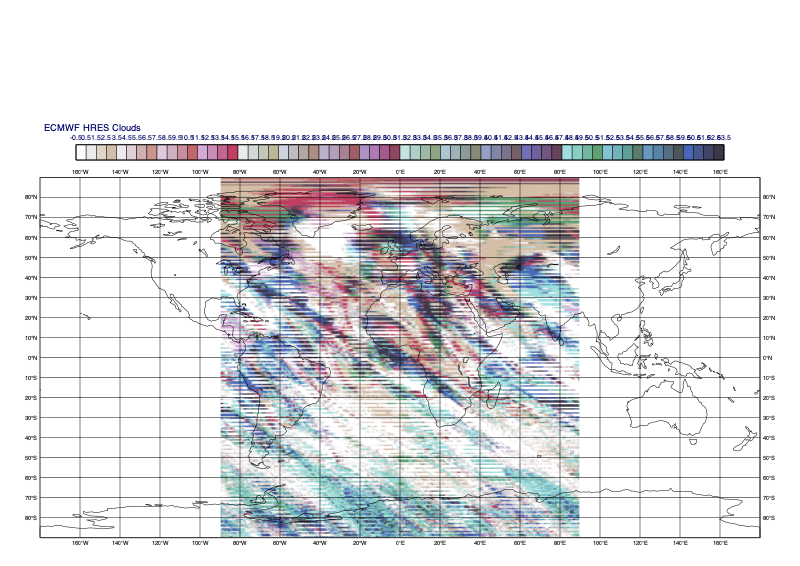

In [4]:
plot()